<a href="https://colab.research.google.com/github/agron-gojcaj/IntrusionDetection/blob/main/Ablation_Study_Intrusion_Detection_NSLKDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === SETUP ===
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import matplotlib.pyplot as plt


#  DATA LOADING & PREPROCESSING

train_df = pd.read_csv('kdd_train.csv')
test_df = pd.read_csv('kdd_test.csv')

categorical_cols = ['protocol_type', 'service', 'flag']
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# Convert labels to binary: 0 for "normal", 1 for anomaly
train_df['labels'] = train_df['labels'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['labels'] = test_df['labels'].apply(lambda x: 0 if x == 'normal' else 1)

X_train = train_df.drop('labels', axis=1).values.astype(np.float32)
y_train = train_df['labels'].values.astype(np.int32)
X_test = test_df.drop('labels', axis=1).values.astype(np.float32)
y_test = test_df['labels'].values.astype(np.int32)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1).float()
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1).float()

train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# MODELS

class SimpleNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)


#    TRAINING FUNCTIONS


# --- Standard NN training (fixed hyperparams) ---
def train_nn():
    model = SimpleNN(X_train.shape[1], dropout_rate=0.2).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(10):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor.to(device)).cpu().numpy()
    return (y_pred > 0.5).astype(int).flatten()

# --- NN training with epoch-by-epoch tracking ---
def train_nn_with_tracking(lr=0.001, dropout_rate=0.2, epochs=10):
    """
    Train a SimpleNN with specified hyperparameters and track
    train/test accuracy & loss each epoch.
    """
    model = SimpleNN(X_train.shape[1], dropout_rate).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_acc_list, train_loss_list = [], []
    test_acc_list, test_loss_list = [], []

    def compute_metrics(mod, X_t, y_t):
        mod.eval()
        with torch.no_grad():
            out = mod(X_t.to(device))
            loss_val = criterion(out, y_t.to(device)).item()
            preds = (out.cpu().numpy() > 0.5).astype(int).flatten()
            labels = y_t.numpy().flatten()
            acc_val = accuracy_score(labels, preds)
        return acc_val, loss_val

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct_samples = 0
        total_samples = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
            preds_batch = (pred.detach().cpu().numpy() > 0.5).astype(int).flatten()
            labels_batch = yb.cpu().numpy().flatten()
            correct_samples += (preds_batch == labels_batch).sum()
            total_samples += xb.size(0)
        train_loss_list.append(epoch_loss / total_samples)
        train_acc_list.append(correct_samples / total_samples)

        val_acc, val_loss = compute_metrics(model, X_test_tensor, y_test_tensor)
        test_acc_list.append(val_acc)
        test_loss_list.append(val_loss)
    model.eval()
    with torch.no_grad():
        out_test = model(X_test_tensor.to(device))
    final_preds = (out_test.cpu().numpy() > 0.5).astype(int).flatten()
    return train_acc_list, train_loss_list, test_acc_list, test_loss_list, final_preds

# --- NN training function used for ablation; now with weight decay ---
def train_nn_custom(lr=0.001, dropout_rate=0.2, weight_decay=0.0, epochs=10):
    """
    Train a SimpleNN with specified hyperparameters.
    Includes weight decay (L2 regularization) via the Adam optimizer.
    Returns final binary predictions.
    """
    model = SimpleNN(X_train.shape[1], dropout_rate=dropout_rate).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor.to(device)).cpu().numpy()
    return (y_pred > 0.5).astype(int).flatten()

# --- RF and SVM training ---
def train_rf():
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

def train_svm():
    clf = SVC(kernel='rbf', gamma='scale')
    clf.fit(X_train[:5000], y_train[:5000])
    return clf.predict(X_test[:5000]), y_test[:5000]

def get_metrics(y_true, y_pred, name):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred)
    }


#    RUN MAIN MODELS (DEFAULT CONFIG)

results = []

# NN with default hyperparameters
y_pred_nn = train_nn()
results.append(get_metrics(y_test, y_pred_nn, "SimpleNN"))

# Random Forest
y_pred_rf = train_rf()
results.append(get_metrics(y_test, y_pred_rf, "Random Forest"))

# SVM (on subset)
y_pred_svm, y_test_svm = train_svm()
results.append(get_metrics(y_test_svm, y_pred_svm, "SVM (subset)"))

df_results = pd.DataFrame(results)

# Also run epoch-by-epoch tracking for the default NN config
train_acc, train_loss, test_acc, test_loss, final_preds = train_nn_with_tracking(lr=0.001, dropout_rate=0.2, epochs=10)


#  ABLATION STUDIES

def ablation_study_nn():
    """
    Test different combinations of learning rate, dropout, and weight decay.
    """
    learning_rates = [0.001, 0.0005]
    dropouts = [0.2, 0.3, 0.5]
    weight_decays = [1e-5]
    epochs = 5
    combos = itertools.product(learning_rates, dropouts, weight_decays)
    results_ablation = []
    for lr, dr, wd in combos:
        y_pred = train_nn_custom(lr=lr, dropout_rate=dr, weight_decay=wd, epochs=epochs)
        results_ablation.append(get_metrics(y_test, y_pred, f"NN(lr={lr},drop={dr},wd={wd})"))
    return pd.DataFrame(results_ablation)

def ablation_study_rf():
    n_estimators_list = [50, 100]
    max_depth_list = [None, 10]
    combos = itertools.product(n_estimators_list, max_depth_list)
    results_rf = []
    for n_est, depth in combos:
        clf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        model_name = f"RF(n={n_est},depth={depth})"
        results_rf.append(get_metrics(y_test, y_pred, model_name))
    return pd.DataFrame(results_rf)

def ablation_study_svm():
    c_values = [0.1, 1.0]
    gamma_list = ["scale", "auto"]
    kernel_list = ["rbf", "linear"]
    combos = itertools.product(c_values, gamma_list, kernel_list)
    results_svm = []
    X_train_svm = X_train[:5000]
    y_train_svm = y_train[:5000]
    X_test_svm_ = X_test[:5000]
    y_test_svm_ = y_test[:5000]
    for c_val, gm, kn in combos:
        clf = SVC(C=c_val, gamma=gm, kernel=kn, random_state=42)
        clf.fit(X_train_svm, y_train_svm)
        preds_svm = clf.predict(X_test_svm_)
        model_name = f"SVM(C={c_val},gamma={gm},kernel={kn})"
        results_svm.append(get_metrics(y_test_svm_, preds_svm, model_name))
    return pd.DataFrame(results_svm)

df_ablation_nn = ablation_study_nn()
df_ablation_rf = ablation_study_rf()
df_ablation_svm = ablation_study_svm()

# Identify best NN config by highest test accuracy from NN ablation
best_nn = df_ablation_nn.loc[df_ablation_nn["Accuracy"].idxmax()]
best_rf = df_ablation_rf.loc[df_ablation_rf["Accuracy"].idxmax()]
best_svm = df_ablation_svm.loc[df_ablation_svm["Accuracy"].idxmax()]

df_best = pd.DataFrame([best_nn, best_rf, best_svm], columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])

print(">>> Training & ablation done. DataFrames available:")
print("df_results:", df_results.shape)
print("df_ablation_nn:", df_ablation_nn.shape)
print("df_ablation_rf:", df_ablation_rf.shape)
print("df_ablation_svm:", df_ablation_svm.shape)
print("df_best:", df_best.shape)
print("using a separate cell to plot your results and customize ylim as needed")


>>> Training & ablation done. DataFrames available:
df_results: (3, 5)
df_ablation_nn: (6, 5)
df_ablation_rf: (4, 5)
df_ablation_svm: (8, 5)
df_best: (3, 5)
You can use a separate cell to plot your results and customize ylim as needed!


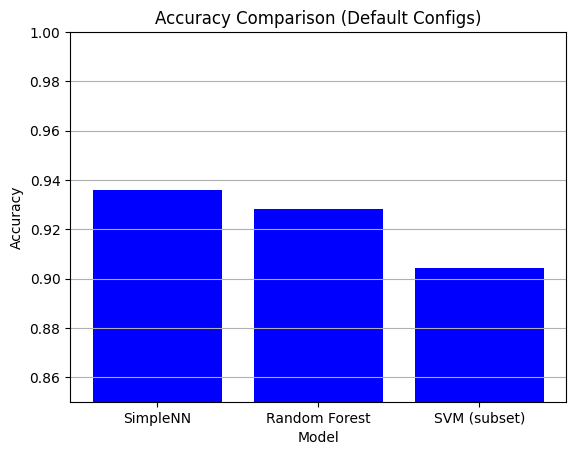

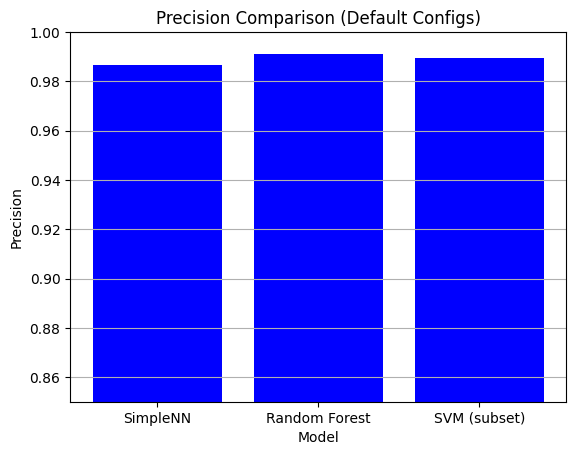

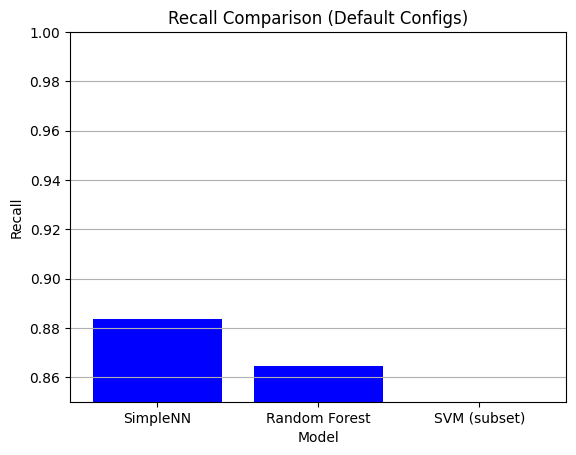

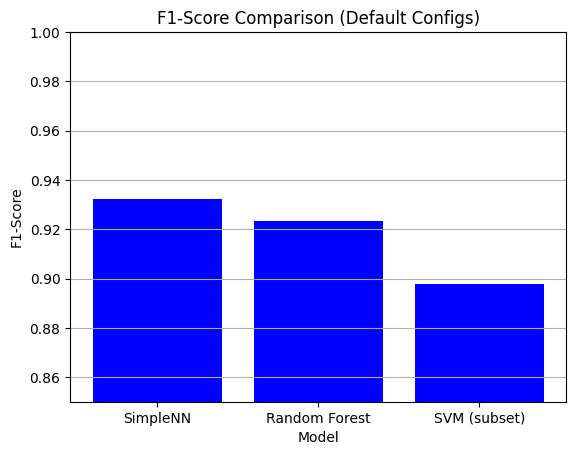

=== Overall Model Comparison (Default) ===
           Model  Accuracy  Precision    Recall  F1-Score
0       SimpleNN  0.935726   0.986756  0.883618  0.932343
1  Random Forest  0.928141   0.991071  0.864413  0.923419
2   SVM (subset)  0.904400   0.989637  0.821666  0.897863


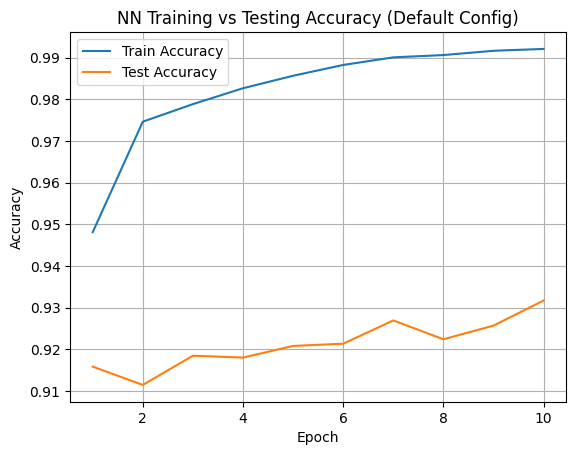

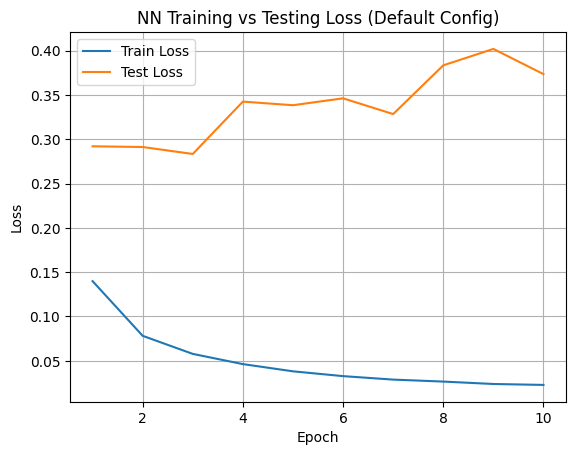


=== Ablation Study: NN ===
                             Model  Accuracy  Precision    Recall  F1-Score
0   NN(lr=0.001,drop=0.2,wd=1e-05)  0.921886   0.985938  0.856359  0.916592
1   NN(lr=0.001,drop=0.3,wd=1e-05)  0.930447   0.988553  0.871316  0.926240
2   NN(lr=0.001,drop=0.5,wd=1e-05)  0.923172   0.984994  0.859811  0.918155
3  NN(lr=0.0005,drop=0.2,wd=1e-05)  0.916962   0.986480  0.845916  0.910806
4  NN(lr=0.0005,drop=0.3,wd=1e-05)  0.918471   0.984335  0.850872  0.912750
5  NN(lr=0.0005,drop=0.5,wd=1e-05)  0.908357   0.984468  0.830250  0.900807


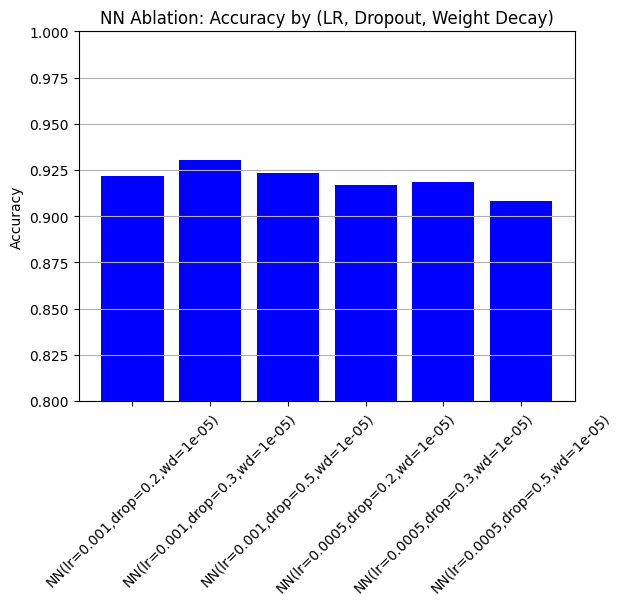


=== Ablation Study: Random Forest ===
                  Model  Accuracy  Precision    Recall  F1-Score
0   RF(n=50,depth=None)  0.932044   0.991347  0.872024  0.927865
1     RF(n=50,depth=10)  0.926588   0.990939  0.861404  0.921642
2  RF(n=100,depth=None)  0.928141   0.991071  0.864413  0.923419
3    RF(n=100,depth=10)  0.926189   0.991131  0.860430  0.921167


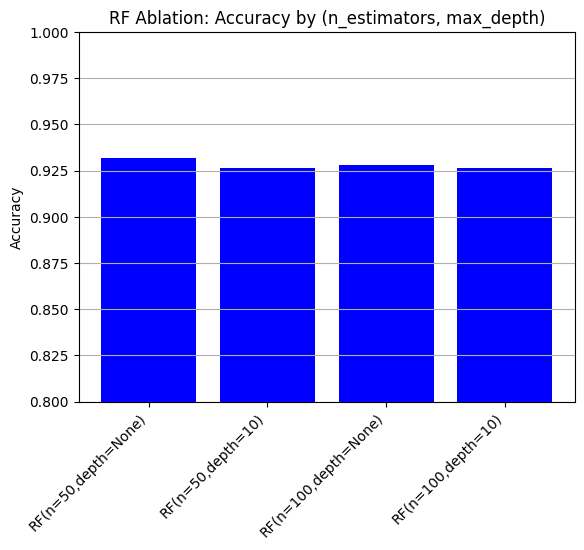


=== Ablation Study: SVM ===
                                  Model  Accuracy  Precision    Recall  \
0     SVM(C=0.1,gamma=scale,kernel=rbf)    0.8982   0.988550  0.810325   
1  SVM(C=0.1,gamma=scale,kernel=linear)    0.8910   0.972300  0.809934   
2      SVM(C=0.1,gamma=auto,kernel=rbf)    0.8792   0.947320  0.808760   
3   SVM(C=0.1,gamma=auto,kernel=linear)    0.8910   0.972300  0.809934   
4     SVM(C=1.0,gamma=scale,kernel=rbf)    0.9044   0.989637  0.821666   
5  SVM(C=1.0,gamma=scale,kernel=linear)    0.8916   0.976810  0.807196   
6      SVM(C=1.0,gamma=auto,kernel=rbf)    0.8938   0.979640  0.809151   
7   SVM(C=1.0,gamma=auto,kernel=linear)    0.8916   0.976810  0.807196   

   F1-Score  
0  0.890608  
1  0.883721  
2  0.872574  
3  0.883721  
4  0.897863  
5  0.883940  
6  0.886271  
7  0.883940  


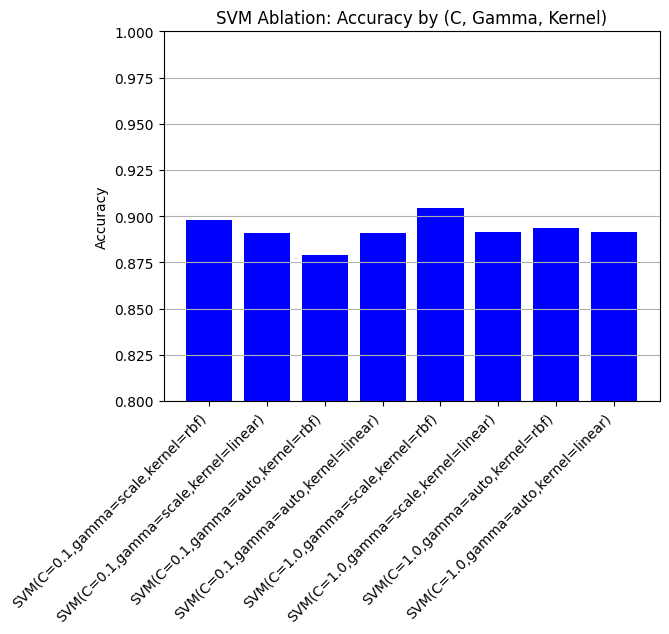


=== Best Config from Each Ablation (by Accuracy) ===
                               Model  Accuracy  Precision    Recall  F1-Score
1     NN(lr=0.001,drop=0.3,wd=1e-05)  0.930447   0.988553  0.871316  0.926240
0                RF(n=50,depth=None)  0.932044   0.991347  0.872024  0.927865
4  SVM(C=1.0,gamma=scale,kernel=rbf)  0.904400   0.989637  0.821666  0.897863


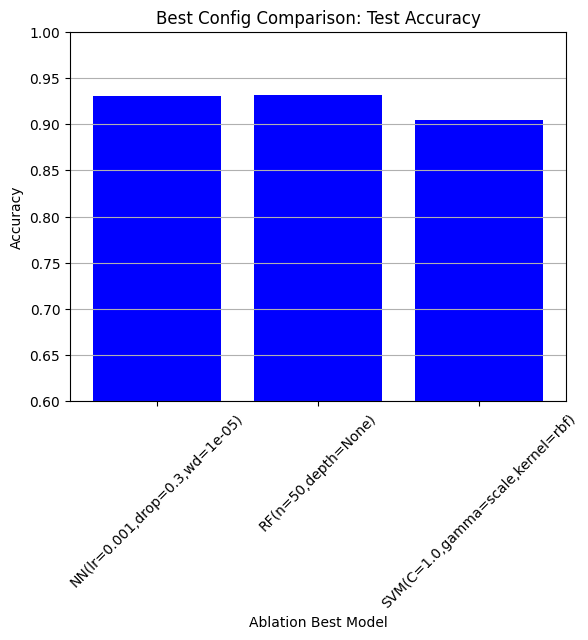

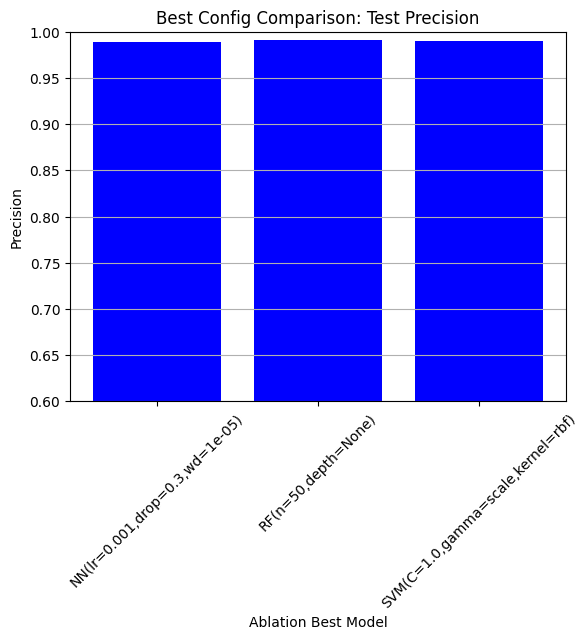

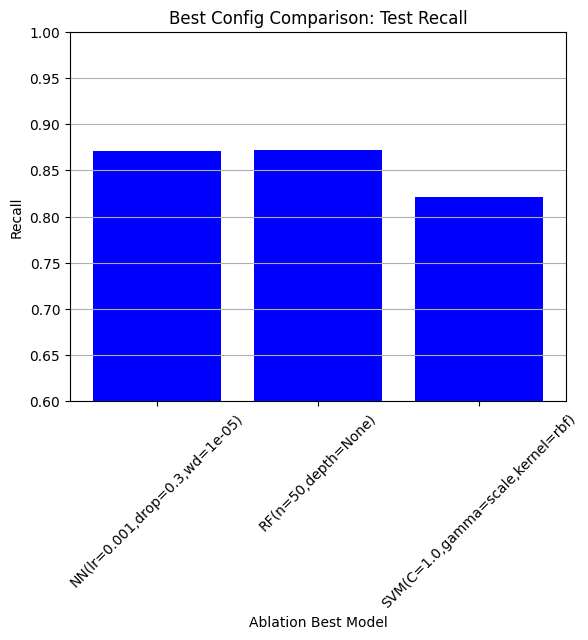

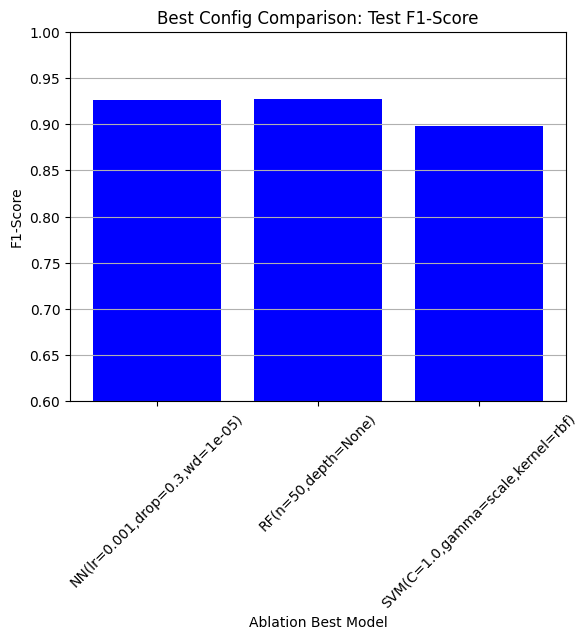

Best NN config: lr = 0.001, dropout = 0.3


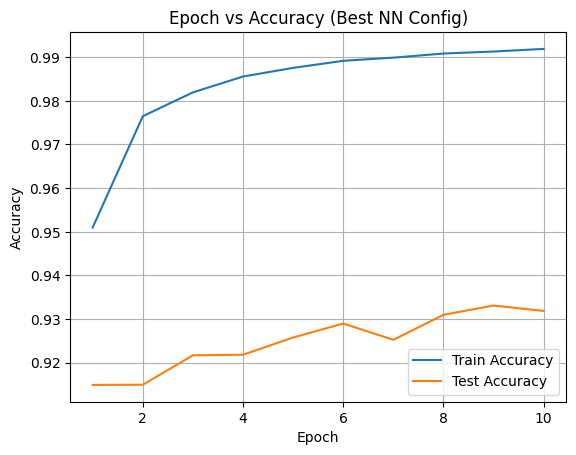

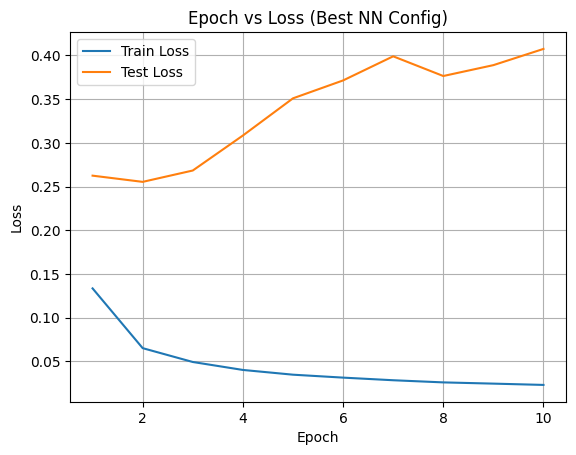

In [ ]:
import re
import matplotlib.pyplot as plt

# 1) Bar plots for default model results
metrics_list = ["Accuracy", "Precision", "Recall", "F1-Score"]
for metric in metrics_list:
    plt.figure()
    plt.bar(df_results["Model"], df_results[metric], color='blue')
    plt.title(f"{metric} Comparison (Default Configs)")
    plt.ylabel(metric)
    plt.ylim(0.85, 1.0)  # adjust as needed
    plt.xlabel("Model")
    plt.grid(axis='y')
    plt.show()

print("=== Overall Model Comparison (Default) ===")
print(df_results)

# 2) Plot epoch vs. accuracy (train & test) for default NN config
plt.figure()
plt.plot(range(1, len(train_acc)+1), train_acc, label='Train Accuracy')
plt.plot(range(1, len(test_acc)+1), test_acc, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("NN Training vs Testing Accuracy (Default Config)")
plt.legend()
plt.grid()
plt.show()

# 3) Plot epoch vs. loss (train & test) for default NN config
plt.figure()
plt.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("NN Training vs Testing Loss (Default Config)")
plt.legend()
plt.grid()
plt.show()

# 4) NN ablation results
print("\n=== Ablation Study: NN ===")
print(df_ablation_nn)
plt.figure()
plt.bar(df_ablation_nn["Model"], df_ablation_nn["Accuracy"], color='blue')
plt.title("NN Ablation: Accuracy by (LR, Dropout, Weight Decay)")
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

# 5) RF ablation results
print("\n=== Ablation Study: Random Forest ===")
print(df_ablation_rf)
plt.figure()
plt.bar(df_ablation_rf["Model"], df_ablation_rf["Accuracy"], color='blue')
plt.title("RF Ablation: Accuracy by (n_estimators, max_depth)")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

# 6) SVM ablation results
print("\n=== Ablation Study: SVM ===")
print(df_ablation_svm)
plt.figure()
plt.bar(df_ablation_svm["Model"], df_ablation_svm["Accuracy"], color='blue')
plt.title("SVM Ablation: Accuracy by (C, Gamma, Kernel)")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

# 7) Compare best from ablation (test metrics)
print("\n=== Best Config from Each Ablation (by Accuracy) ===")
print(df_best)
for metric in ["Accuracy", "Precision", "Recall", "F1-Score"]:
    plt.figure()
    plt.bar(df_best["Model"], df_best[metric], color='blue')
    plt.title(f"Best Config Comparison: Test {metric}")
    plt.ylabel(metric)
    plt.ylim(0.6, 1.0)
    plt.xlabel("Ablation Best Model")
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.show()

# 8) Plot epoch vs. accuracy & loss for the best NN configuration from ablation
# Extract best NN parameters from best_nn["Model"], assumed format: "NN(lr=0.001,drop=0.2,wd=0.0)"
best_nn_str = best_nn["Model"]
match = re.search(r"NN\(lr=([\d\.]+),drop=([\d\.]+),wd=([\d\.e-]+)\)", best_nn_str)
if match:
    best_lr = float(match.group(1))
    best_dropout = float(match.group(2))
    best_wd = float(match.group(3))  # Not used further, but available for reference.
else:
    best_lr = 0.001
    best_dropout = 0.2
print(f"Best NN config: lr = {best_lr}, dropout = {best_dropout}")

# Re-run epoch tracking for best NN config:
best_train_acc, best_train_loss, best_test_acc, best_test_loss, _ = train_nn_with_tracking(
    lr=best_lr, dropout_rate=best_dropout, epochs=10
)

plt.figure()
plt.plot(range(1, len(best_train_acc)+1), best_train_acc, label="Train Accuracy")
plt.plot(range(1, len(best_test_acc)+1), best_test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy (Best NN Config)")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(range(1, len(best_train_loss)+1), best_train_loss, label="Train Loss")
plt.plot(range(1, len(best_test_loss)+1), best_test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss (Best NN Config)")
plt.legend()
plt.grid()
plt.show()
